In [9]:
from google.colab import files
uploaded = files.upload()

Saving squares_7.tiff to squares_7 (1).tiff


In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as image_plt
import numpy as np
from numpy import pi
from numpy import asarray
import math
import imageio
from PIL import Image
from itertools import combinations
from scipy.sparse import linalg
from scipy import stats
from scipy.stats import rv_discrete
from scipy.sparse import coo_matrix
import cv2
import glob
import networkx as nx
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image
import pandas as pd
import scipy.sparse.linalg as sla

In [11]:
def get_list_of_images():
    list_images = uploaded.keys()
    return list_images
    
def create_network(adjacency_matrix, edges):
    # Identify working pixels
    number_of_pixels = adjacency_matrix.shape[0]

    # Populate a networkx graph with pixels as nodes.
    working_graph = nx.Graph()
    for node in range(number_of_pixels):
        working_graph.add_node(node)

    # Pair up all neighbors with random weights in working_graph.
    for pixel in edges:
        working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])

    #nx.draw_circular(working_graph, node_size=1000, with_labels=True)
    #plt.show()

    return working_graph, number_of_pixels

def compute_cut_size(labels, graph):
    df = pd.Series(labels)
    one_qubits = set(df[df==1].index)
    S_partition = set()
    T_partition = set()

    for node in graph:
        if node in one_qubits:
            # If a one was measured add node to S partition.
            S_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.
            T_partition.add(node)

    cut_size = nx.normalized_cut_size(
                graph, S_partition, T_partition, weight='weight')
    return cut_size

In [12]:
def open_images(image):
    img = Image.open(image)
    image_array = np.asarray(img)
    return img, image_array

def create_adjacency_from_image(image_array):
    sigma = 255*.15
    imag = image_array.astype(float)
    graph = image.img_to_graph(imag)
    graph.data = np.exp(-np.square(graph.data / sigma)/2)
    adjacency = graph.toarray()-np.diag(np.diag(graph.toarray()))
    return adjacency

def compute_normalized_laplacian(adjacency_matrix):
    degree = np.matrix(np.diag(np.sqrt(np.power(np.sum(adjacency_matrix,axis=1),-1))))
    adjacency_normalized_cuts = np.matmul(degree,np.matmul(adjacency_matrix,degree))
    return adjacency_normalized_cuts

def compute_edges(adjacency_matrix):
    edges = []
    for i in range(adjacency_matrix.shape[0]):
      for j in range(i, adjacency_matrix.shape[0]):
        if adjacency_matrix[i,j]!=0 and i!=j:
          edges.append((i,j))
    return edges

def compute_average_std_of_cuts(total_cuts):
    cut_tot = np.array(total_cuts)
    average = np.around(cut_tot.mean(),6)
    std_dev = np.around(cut_tot.std(),6)
    return average, std_dev

In [13]:
def main():
    image_list = get_list_of_images()
    results = []
    for image_name in image_list:
        img, image_array = open_images(image_name)

        adjacency = create_adjacency_from_image(image_array)
        
        adjacency_n = compute_normalized_laplacian(adjacency)

        graph = coo_matrix(adjacency_n, dtype=np.float64)
        edges = compute_edges(adjacency_n)
        
        nx_graph, qubits = create_network(adjacency, edges)

        cut_list = []
        best_cut = np.inf
        for i in range(10):
            labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
            cut_size = compute_cut_size(labels, nx_graph)
            cut_list.append(cut_size)
            if cut_size < best_cut:
                best_cut = cut_size

        average_cut, std_cuts = compute_average_std_of_cuts(cut_list)
        results.append([best_cut, average_cut, std_cuts])
    return results

In [14]:
import pandas as pd

results = main()
results_df = pd.DataFrame(results)
results_df.to_excel("Results_Spectral_Clustering_SKLearn.xlsx") 
results_df

,0,1,2
0,0.248798,0.248798,0.0


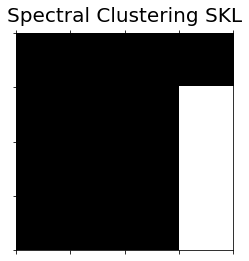

In [16]:
image_list = ['squares_4.tiff', 'squares_8.tiff','squares_12.tiff', 'squares_16.tiff','squares_20.tiff', 'squares_24.tiff', 'squares_28.tiff',]
image_list = get_list_of_images()
for image_name in image_list:
    img, image_array = open_images(image_name)

    adjacency = create_adjacency_from_image(image_array)
    mask = image_array.astype(bool)
    adjacency_n = compute_normalized_laplacian(adjacency)
  
    graph = coo_matrix(adjacency, dtype=np.float64)
    edges = compute_edges(adjacency_n)
    nx_graph, qubits = create_network(adjacency_n, edges)
    
    labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
    label_im = labels.reshape((4,4))

    #plt.matshow(img)
    fig, axs = plt.subplots(1,1, figsize = (3.5,3.5), constrained_layout=True, sharey=True)
    axs.matshow(label_im, cmap=plt.get_cmap('gray'))
    axs.set_title('Spectral Clustering SKL', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
    axs.set_xticks(np.arange(-0.5,4.5))
    axs.set_yticks(np.arange(-0.5,4.5))
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.show()